In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


In [4]:
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

HOCOMOCOv11_core_HUMAN_mono_meme_format.meme
HOCOMOCOv11_core_MOUSE_mono_meme_format.meme
JASPAR2018_CORE_vertebrates_non-redundant_pfms.meme
table_s3-1.meme
table_s3-2.meme
table_s3-3.meme
table_s3-4.meme
table_s3-5.meme
table_s3-6.meme
# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:
# len(reduces_groups)

In [8]:
# reduced_groups = mb.tl.reduce_filters([p.to_numpy() for p in pwms[:10]], thr_group=0.03, plot=False)

In [9]:
# reduced_groups = reduced_groups[:4]
# reduced_groups = reduced_groups[:1]

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Using device: cuda:0


In [11]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [12]:
import scanpy as sc

In [13]:
# atac_path = '../../../annotations/scatac/ancreas_multiome_2022_processed_sample_c16918_p50000.h5ad'
all_path = '../../../annotations/scatac/pancreas_multiome_2022_processed.h5ad'
atac_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_atac.h5ad'
rna_path = '../../../annotations/scatac/pancreas_multiome_2022_processed_rna.h5ad'
if not os.path.exists(atac_path):
    print('preparing atac...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    atac = adata[:,adata.var.modality == 'ATAC'].copy()
    print(atac.shape)
    atac.write(atac_path, compression='lzf')
if not os.path.exists(rna_path):
    print('preparing rna...')
    adata = sc.read_h5ad(all_path)
    print(adata.shape)
    rna = adata[:,adata.var.modality == 'GEX'].copy()
    print(rna.shape)
    rna.write(rna_path, compression='lzf')

In [14]:
atac = sc.read_h5ad(atac_path)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

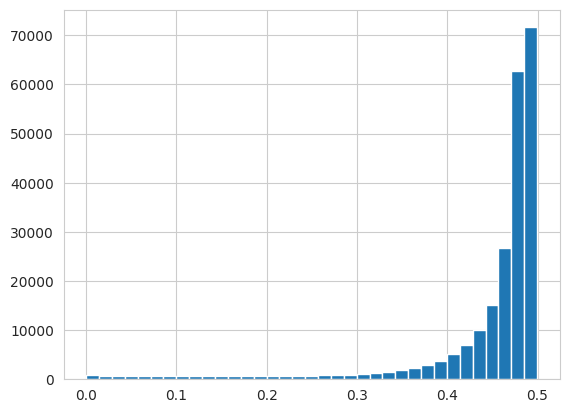

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)

In [16]:
n_sample_cells = 500
n_sample_peaks = 1000
obs_sample = pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(500, 1000)

In [17]:
ad.shape

(500, 1000)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


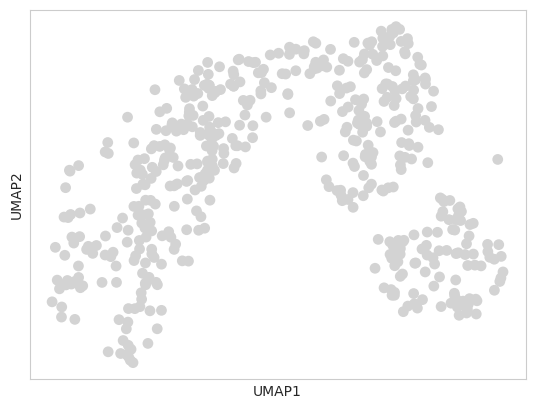

In [18]:
sc.pl.umap(ad)

In [19]:
ad.var

modality  acc_score  acc_score_rank
1-31807838-31808745       ATAC   0.448812        170197.0
1-36634685-36635569       ATAC   0.373744        204741.0
1-36647357-36648266       ATAC   0.405899        196377.0
1-39361792-39362685       ATAC   0.425878        187553.5
1-41361310-41362225       ATAC   0.484218         78646.5
...                        ...        ...             ...
X-140388387-140389297     ATAC   0.487469         53292.5
X-140668906-140669684     ATAC   0.493380          6721.0
X-150826370-150827305     ATAC   0.494385          3123.0
X-159060101-159060924     ATAC   0.490720         23701.5
X-163858136-163858677     ATAC   0.440359        177941.5

[1000 rows x 3 columns]

In [20]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

In [21]:
extend = 50

ad.var['chr'].value_counts()

chr5     92
chr4     71
chr13    66
chr2     65
chr11    61
chr6     56
chr3     55
chr1     53
chr10    52
chr8     52
chr9     50
chr7     46
chr16    43
chr14    42
chr17    42
chr18    38
chr12    34
chr15    31
chrX     26
chr19    25
Name: chr, dtype: int64

In [22]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [23]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

convert bed to fasta
/tmp/tmpr48yuv76
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpr48yuv76 -fo /tmp/tmp_3lggato
get fasta
/tmp/tmp_3lggato


1000

In [24]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [25]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [26]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [27]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(1000, 501)

In [28]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [29]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [30]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [31]:
next_data_sel

0    1    2    3    4  \
seq                                                                           
GGAGCACGGCCAGCCCTCGCCGCAAGCAAGCTTGCTAGTCCTCCATG...  1.0  0.0  2.0  0.0  0.0   
TCCGTATGCTAATAAAGGGGCGGAACTTGCGAGGCAAAACCGGCTCT...  0.0  0.0  1.0  3.0  0.0   
GGCGCCACACGGTGAAGGTGACGCCGAGCACCGTGCTGCTGCAGGTG...  1.0  0.0  2.0  1.0  2.0   
CCGTCACCGCCCCGGCAGCCGCGGGAGGCCCGCGCCGCCACGCCCCC...  1.0  0.0  2.0  3.0  1.0   
TAACCTCTCTTCTTGAATAATACAGCAAGACTCACAGTCTCCGGTCC...  0.0  2.0  2.0  0.0  1.0   
...                                                 ...  ...  ...  ...  ...   
CTCTTAACCACTGAATTCTCTCTCCAACCCCCAAATGAAAGCTTAAC...  0.0  0.0  0.0  0.0  0.0   
CAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGAGGCAGTGG...  0.0  0.0  0.0  0.0  0.0   
GAGCACATGGCAGTGCACATCACAGTGGGGAGCAGTGGCAGTGCACA...  0.0  0.0  0.0  0.0  0.0   
GAGCATGGTCTGGAGGGTACCTTGGATTATCAAGAGCCCTTGAGTTT...  0.0  0.0  0.0  0.0  0.0   
TTTAAAAGAGAGGCAATTTAATTACAAGGACACACAAAAGCTATCAG...  0.0  0.0  0.0  0.0  0.0   

                                                      5    6    7    8    9  \
seq                                                                           
GGAGCACGGCCAGCCCTCGCCGCAAGCAAGCTTGCTAGTCCTCCATG...  2.0  2.0  1.0  3.0  4.0   
TCCGTATGCTAATAAAGGGGCGGAACTTGCGAGGCAAAACCGGCTCT...  1.0  0.0  2.0  2.0  0.0   
GGCGCCACACGGTGAAGGTGACGCCGAGCACCGTGCTGCTGCAGGTG...  1.0  1.0  0.0  3.0  2.0   
CCGTCACCGCCCCGGCAGCCGCGGGAGGCCCGCGCCGCCACGCCCCC...  0.0  0.0  2.0  2.0  2.0   
TAACCTCTCTTCTTGAATAATACAGCAAGACTCACAGTCTCCGGTCC...  2.0  1.0  3.0  1.0  3.0   
...                                                 ...  ...  ...  ...  ...   
CTCTTAACCACTGAATTCTCTCTCCAACCCCCAAATGAAAGCTTAAC...  0.0  0.0  0.0  0.0  0.0   
CAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGAGGCAGTGG...  0.0  0.0  0.0  0.0  0.0   
GAGCACATGGCAGTGCACATCACAGTGGGGAGCAGTGGCAGTGCACA...  0.0  0.0  0.0  0.0  0.0   
GAGCATGGTCTGGAGGGTACCTTGGATTATCAAGAGCCCTTGAGTTT...  0.0  0.0  0.0  0.0  0.0   
TTTAAAAGAGAGGCAATTTAATTACAAGGACACACAAAAGCTATCAG...  0.0  0.0  0.0  0.0  0.0   

                                                    ...  491  492  493  494  \
seq                                                 ...                       
GGAGCACGGCCAGCCCTCGCCGCAAGCAAGCTTGCTAGTCCTCCATG...  ...  2.0  1.0  2.0  1.0   
TCCGTATGCTAATAAAGGGGCGGAACTTGCGAGGCAAAACCGGCTCT...  ...  1.0  0.0  0.0  1.0   
GGCGCCACACGGTGAAGGTGACGCCGAGCACCGTGCTGCTGCAGGTG...  ...  1.0  0.0  3.0  0.0   
CCGTCACCGCCCCGGCAGCCGCGGGAGGCCCGCGCCGCCACGCCCCC...  ...  1.0  1.0  2.0  0.0   
TAACCTCTCTTCTTGAATAATACAGCAAGACTCACAGTCTCCGGTCC...  ...  1.0  3.0  2.0  1.0   
...                                                 ...  ...  ...  ...  ...   
CTCTTAACCACTGAATTCTCTCTCCAACCCCCAAATGAAAGCTTAAC...  ...  0.0  0.0  0.0  0.0   
CAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGAGGCAGTGG...  ...  0.0  0.0  0.0  0.0   
GAGCACATGGCAGTGCACATCACAGTGGGGAGCAGTGGCAGTGCACA...  ...  0.0  0.0  0.0  0.0   
GAGCATGGTCTGGAGGGTACCTTGGATTATCAAGAGCCCTTGAGTTT...  ...  0.0  0.0  0.0  0.0   
TTTAAAAGAGAGGCAATTTAATTACAAGGACACACAAAAGCTATCAG...  ...  0.0  0.0  0.0  0.0   

                                                    495  496  497  498  499  \
seq                                                                           
GGAGCACGGCCAGCCCTCGCCGCAAGCAAGCTTGCTAGTCCTCCATG...  1.0  0.0  0.0  2.0  0.0   
TCCGTATGCTAATAAAGGGGCGGAACTTGCGAGGCAAAACCGGCTCT...  0.0  0.0  1.0  0.0  0.0   
GGCGCCACACGGTGAAGGTGACGCCGAGCACCGTGCTGCTGCAGGTG...  1.0  0.0  0.0  4.0  0.0   
CCGTCACCGCCCCGGCAGCCGCGGGAGGCCCGCGCCGCCACGCCCCC...  0.0  0.0  0.0  1.0  0.0   
TAACCTCTCTTCTTGAATAATACAGCAAGACTCACAGTCTCCGGTCC...  2.0  0.0  1.0  2.0  0.0   
...                                                 ...  ...  ...  ...  ...   
CTCTTAACCACTGAATTCTCTCTCCAACCCCCAAATGAAAGCTTAAC...  0.0  0.0  0.0  0.0  0.0   
CAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGGAGGCAGAGGCAGTGG...  0.0  0.0  0.0  0.0  0.0   
GAGCACATGGCAGTGCACATCACAGTGGGGAGCAGTGGCAGTGCACA...  0.0  0.0  0.0  0.0  0.0   
GAGCATGGTCTGGAGGGTACCTTGGATTATCAAGAGCCCTTGAGTTT...  0.0  0.0  0.0  0.0  0.0   
TTTAAAAGAGAGGCAATTTAAT

In [32]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [33]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(997, 500)

In [34]:
ad = ad[:,~zero_counts].copy()


In [35]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(498500, 3)
500
0      997
137    997
127    997
128    997
129    997
      ... 
69     997
70     997
71     997
72     997
199    997
Name: batch, Length: 200, dtype: int64


0    1  batch
seq                                                                
GGAGCACGGCCAGCCCTCGCCGCAAGCAAGCTTGCTAGTCCTCCATG...  1.0  1.0      0
TCCGTATGCTAATAAAGGGGCGGAACTTGCGAGGCAAAACCGGCTCT...  1.0  0.0      0
GGCGCCACACGGTGAAGGTGACGCCGAGCACCGTGCTGCTGCAGGTG...  1.0  1.0      0
CCGTCACCGCCCCGGCAGCCGCGGGAGGCCCGCGCCGCCACGCCCCC...  1.0  1.0      0
TAACCTCTCTTCTTGAATAATACAGCAAGACTCACAGTCTCCGGTCC...  1.0  0.0      0

### Simple motif enrichment

In [36]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [37]:
import ushuffle

fg = df.index
bg = []

for i, s in enumerate(fg):
    # print(i, s)
    bg.append(ushuffle.shuffle(str.encode(s), 2))



In [38]:
for a, b in zip(fg, bg):
    # print(len(a[1]), len(b))
    assert len(a) == len(b)

In [39]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [40]:
reduced_groups = pwms

In [41]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [42]:
df_neg = df.copy()
df_neg.index = bg
df_neg.index = df_neg.index.astype(str)

dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=1024, shuffle=True)


In [43]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")
criterion = mb.tl.PoissonLoss()

w = [r.shape[1] for r in reduced_groups]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# initialize the reduce kernels
for i, mono_best in enumerate(reduced_groups):
    if mono_best.shape[-1] == 0:
        continue
    mono_best = mono_best.to_numpy()
    new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
    model.binding_modes.conv_mono[i + 1].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
model = model.to(device)


In [44]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)
mono.shape, mono_rev.shape

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_fg = {}

for ci in range(bm_pred.shape[1]):
    scores_fg[ci] = bm_pred[:, ci]

0 1207.9233 8604.44
1 6958.3447 63261.926
2 1852.675 6208.09
3 3823.5708 21353.855
4 2606.4192 40279.016
5 2415.501 21544.15
6 7921.0117 76877.66
7 11737.477 449726.94
8 4937.0737 17383.322
9 3369.2002 11503.4
10 4908.0923 32316.947
11 476.83514 18653.01
12 2820.0493 6757.572
13 6850.909 43409.805
14 3256.6887 21000.164
15 2736.4055 24239.57
16 4924.25 292926.22
17 1548.9968 10884.243
18 10002.568 412130.3
19 7387.736 191331.9
20 2037.4736 11702.732
21 3270.6946 10956.968
22 9777.66 74465.016
23 2244.8267 16052.362
24 3138.8416 15694.701
25 2330.8105 50875.17
26 2431.353 207241.47
27 1201.9338 9666.23
28 4724.965 39713.305
29 1808.9375 9054.703
30 2273.35 37906.74
31 4153.0474 19236.072
32 1443.4785 16776.422
33 3225.544 76546.92
34 2299.896 10196.783
35 2041.6727 93397.51
36 2600.5425 24303.074
37 2949.9644 48762.543
38 2232.803 228505.8
39 654.32947 8641212.0
40 1852.0417 32487.39
41 1084.5175 10617.618
42 4154.3403 192338.5
43 8905.555 334865.88
44 6786.3853 610053.1
45 1289.7516 22

In [45]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]


In [46]:
# calculate scores per binding mode, using the binding layer
# unsqueeze mono after preparing di and unsqueezing mono
mono = torch.tensor(train_neg.dataset.mononuc, device=device)
mono_rev = mono
mono_rev = torch.unsqueeze(mono_rev, 1)
mono = torch.unsqueeze(mono, 1)

bm_pred = model.binding_modes(mono, mono_rev)
bm_pred = bm_pred.detach().cpu().numpy()[:,1:]

# 01 normalize
for ci in range(bm_pred.shape[1]):
    v = bm_pred[:, ci]
    vmin, vmax = v.min(), v.max()
    print(ci, vmin, vmax)
    bm_pred[:, ci] = (v - vmin) / (vmax - vmin)

scores_bg = {}

for ci in range(bm_pred.shape[1]):
    scores_bg[ci] = bm_pred[:, ci]

0 1204.7502 7891.0474
1 7091.9146 69851.02
2 1810.92 6890.7993
3 3804.3894 24959.11
4 2683.184 35115.81
5 2654.995 20403.672
6 7515.619 65351.766
7 14021.117 418696.0
8 5177.571 19406.072
9 3395.0305 12157.293
10 5042.7095 39845.47
11 471.453 12765.183
12 2794.0325 7208.907
13 7699.369 33697.688
14 3198.2913 23375.953
15 2606.3604 22748.496
16 3740.6768 266801.06
17 1465.5162 9333.174
18 8758.986 134410.53
19 6983.142 114148.06
20 1970.3667 10324.323
21 3877.743 11748.264
22 9542.775 64314.363
23 2324.334 12481.086
24 3489.5872 15220.142
25 2147.836 49595.594
26 2827.8203 99352.28
27 1221.5266 10764.741
28 4957.2407 38749.766
29 1872.8209 7474.619
30 2542.763 17712.22
31 4084.1477 15147.154
32 1557.7283 7493.0303
33 3489.4265 50944.043
34 2229.3599 9157.311
35 1984.1158 68975.11
36 2706.6167 23342.898
37 3170.4592 57547.87
38 2516.309 191121.31
39 1062.2334 6169380.0
40 1730.1343 25062.984
41 1114.7987 9604.125
42 3565.401 166111.22
43 9166.043 204477.33
44 6558.532 260559.06
45 1181.3

In [47]:
calc_pwm_scores = False
if calc_pwm_scores:
    from numba import jit

    scores_fg = {}
    scores_bg = {}

    def get_scores(entries, kmers):
        scores = []
        # print(entries[0])
        for s in entries:
            # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]

            seq_score = 0
            for k in kmers:
                if k in s or k in s_rev:
                    seq_score = 1
                    break
            scores.append(seq_score)
        return scores

    @jit
    def get_scores(pwm_vals, nts, cols):
        return np.sum(pwm_vals[nts, cols])

    def get_scores_pwm(entries, pwm):
        scores = []
        pwm_vals = pwm.values
        cols = pwm.columns
        np.array(cols)

        for si, s in enumerate(entries):
            # print(si) # print(h, s)
            s = str(s)
            base_for = "ACGT"
            base_rev = "TGCA"
            comp_tab = str.maketrans(base_for, base_rev)
            s_rev = s.translate(comp_tab)[::-1]
            entry_scores = []
            for i in range(len(s) - pwm.shape[1] + 1):
                fwd, rev = [sub[i:i + pwm.shape[1]] for sub in [s, s_rev]]
                # print(len(fwd), len(rev), pwm.shape)
                # score_fwd, score_rev = [np.sum([pwm[ci][nti] for ci, nti in zip(pwm, sub)]) for sub in [fwd, rev]]
                nts = np.array(['ACGT'.find(nt) for nt in fwd])
                score_fwd = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                nts = np.array(['ACGT'.find(nt) for nt in rev])
                score_rev = get_scores(pwm_vals, nts, cols) # np.sum(pwm_vals[nts, cols])
                next_score = score_fwd + score_rev
                entry_scores.append(score_fwd)
                entry_scores.append(score_rev)

            scores.append(max(entry_scores))
        return scores


    for pi, pwm in enumerate(pwms):
        # print(pi)
        pos = get_scores_pwm(fg, pwm)

        # print(mi, m, pos)
        scores_fg[pi] = pos
        neg = get_scores_pwm(bg, pwm)
        scores_bg[pi] = neg
        # print(len(fg), len(bg))
        # if pi % 5 == 0:
        print(pi, np.mean(pos), np.mean(neg))


In [48]:
import sklearn
import numpy as np
import scipy
from statsmodels.stats.multitest import fdrcorrection

res = []
for pi, pwm in enumerate(pwms):
    pos, neg = scores_fg[pi], scores_bg[pi]

    assert len(pos) > 0 and len(neg) > 0
    y_true = np.concatenate([np.repeat(1, len(pos)), np.repeat(0, len(neg))])
    y_score  = np.concatenate([pos, neg])

    roc_auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    pval = scipy.stats.ranksums(pos, neg)[1]
    res.append([pi, roc_auc, np.mean(pos), np.mean(neg), pval])
    # print(m, roc_auc)

res = pd.DataFrame(res, columns=['pwm_id', 'auroc', 'mean_fg', 'mean_bg', 'p_value'])

res['p_adj'] = fdrcorrection(res['p_value'])[1]
res = res.sort_values(['auroc', 'p_value'], ascending=[False, True])
res.head()


pwm_id     auroc   mean_fg   mean_bg        p_value          p_adj
151     151  0.958477  0.188864  0.047770  2.770370e-275  2.641086e-273
196     196  0.888078  0.153784  0.053165  7.768021e-198  1.388534e-196
139     139  0.842206  0.205931  0.107016  2.747279e-154  3.571463e-153
283     283  0.821519  0.101602  0.046616  1.960811e-136  2.002828e-135
174     174  0.810675  0.360533  0.226431  1.614078e-127  1.538754e-126

In [49]:
scores_per_cell_n_module = {}
for pi, pwm in enumerate(pwms):
    pos, neg = np.array(scores_fg[pi]), np.array(scores_bg[pi])
    next_scores = []
    for c in df:
        labels = df[c].values
        cell_is_acc = (labels != 0)
        a = pos[cell_is_acc].mean() - neg[cell_is_acc].mean()
        b = pos[~cell_is_acc].mean() - neg[~cell_is_acc].mean()
        # # print(c, m, a - b)
        # a, b = pos[cell_is_acc], pos[~cell_is_acc]
        # a = a.mean() if len(a) != 0 else 0
        # b = b.mean() if len(b) != 0 else 0
        next_scores.append(a - b)
    scores_per_cell_n_module[pi] = next_scores

In [50]:
scores_kmers = pd.DataFrame(scores_per_cell_n_module)

In [51]:
import seaborn as sns

In [52]:
# scores_kmers
# sns.clustermap(scores_kmers, cmap='RdBu_r', yticklabels=False, xticklabels=False)

In [53]:
scores_kmers.index = ad.obs_names

In [54]:
ad.obsm['kmers'] = scores_kmers

In [55]:
for c in scores_kmers:
    ad.obs[c] = ad.obsm['kmers'][c]

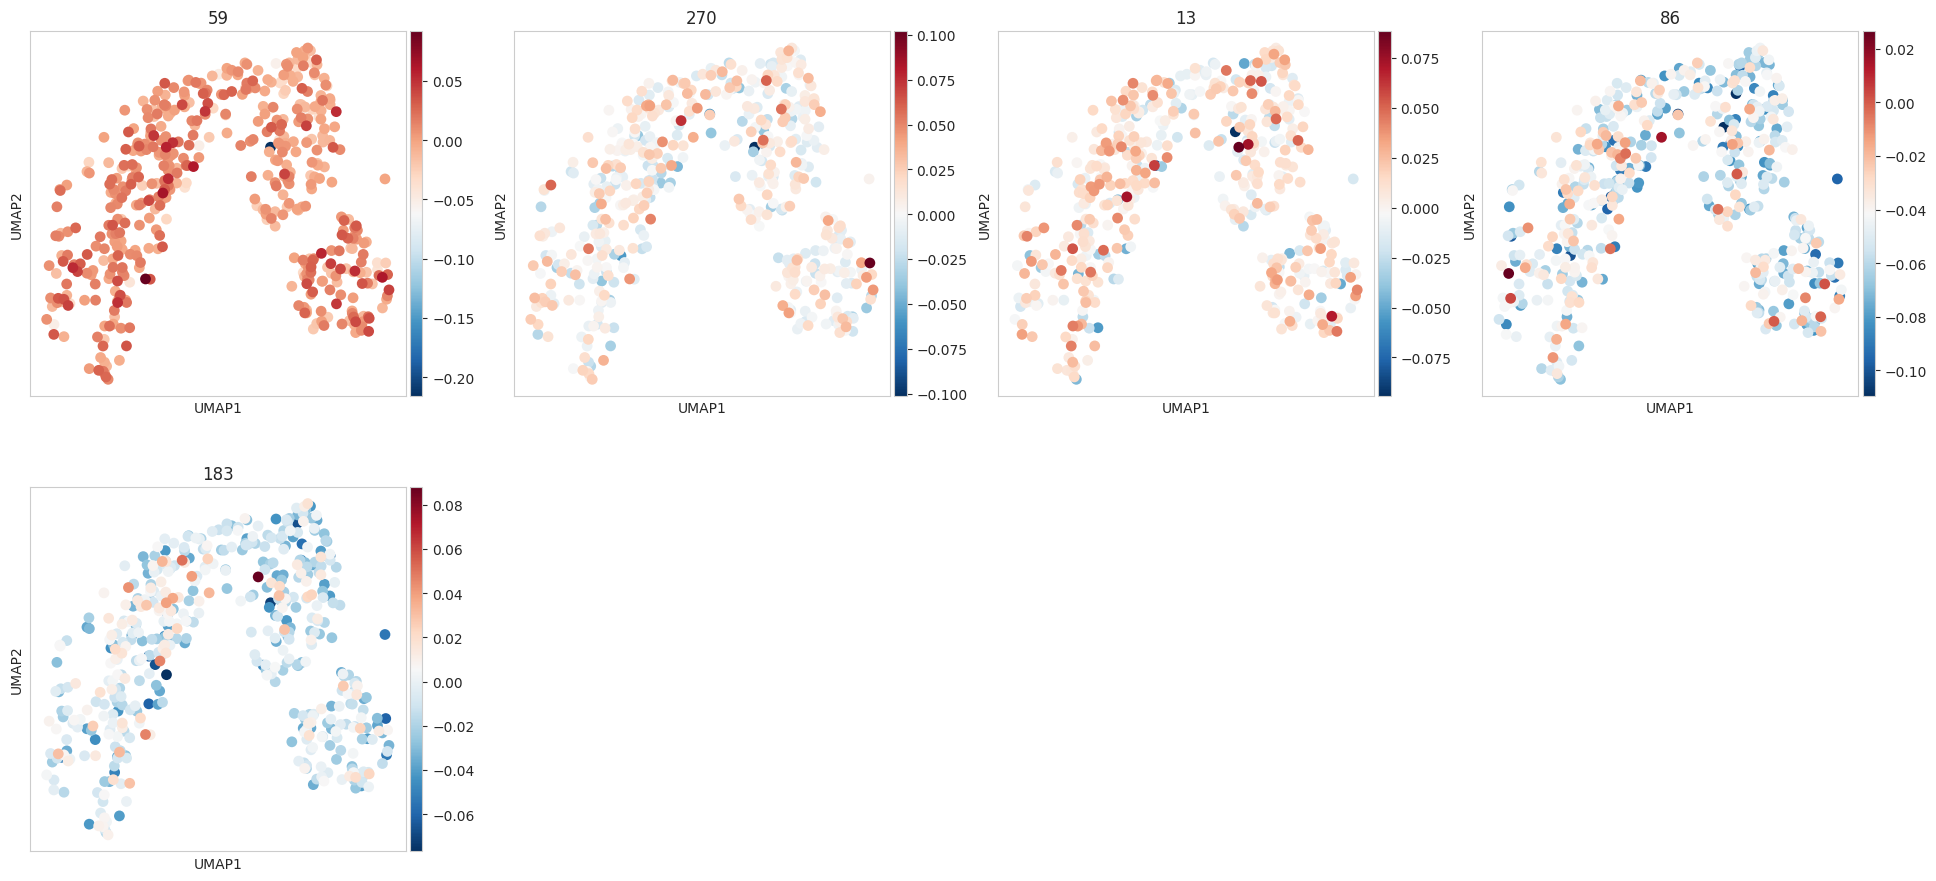

In [56]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5
sc.pl.umap(ad, color=scores_kmers.var(axis=0).sort_values(ascending=False).index[:5], cmap='RdBu_r')

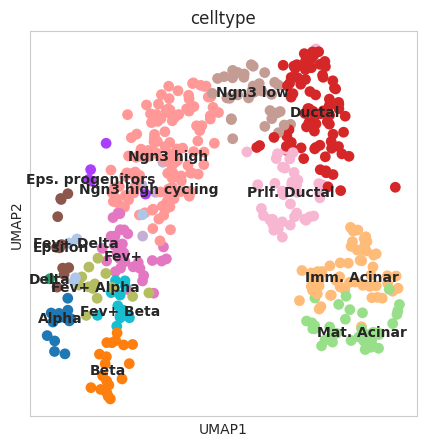

In [57]:
sc.pl.umap(ad, color='celltype', legend_loc='on data')

In [58]:
diff_by_celltype = {}
for c in set(ad.obs['celltype']):
    ad1 = ad[ad.obs['celltype'] == c,:]
    ad2 = ad[ad.obs['celltype'] != c,:]
    s1 = ad1.obs.mean()[ad1.obsm['kmers'].columns]
    s2 = ad2.obs.mean()[ad2.obsm['kmers'].columns]
    diff_by_celltype[c] = s1 - s2
diff_by_celltype = pd.DataFrame(diff_by_celltype)

In [59]:
sel_idx = set()
for c in diff_by_celltype:
    idx = np.argmax(diff_by_celltype[c])
    print(c, idx)
    sel_idx.add(idx)

Eps. progenitors 222
Ngn3 low 127
Imm. Acinar 269
Fev+ Delta 117
Fev+ Beta 116
Epsilon 130
Ductal 8
Ngn3 high 219
Fev+ Alpha 160
Mat. Acinar 173
Prlf. Ductal 214
Fev+ 260
Beta 12
Delta 2
Ngn3 high cycling 10
Alpha 260


In [60]:
sel_idx = sorted(list(sel_idx))
sel_idx

[2, 8, 10, 12, 116, 117, 127, 130, 160, 173, 214, 219, 222, 260, 269]

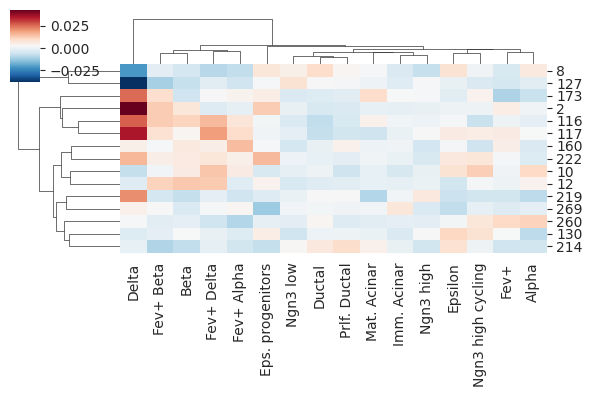

In [61]:
sns.clustermap(diff_by_celltype.reindex(sel_idx), cmap='RdBu_r', figsize=[6, 4])

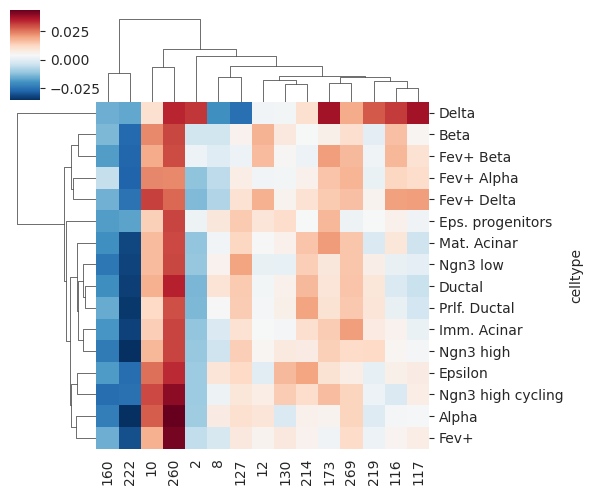

In [62]:
sns.clustermap(ad.obs.groupby('celltype').mean()[sel_idx], cmap='RdBu_r', figsize=[6, 5])

### This is the relatedness graph and used for dynamics filters learning

In [63]:
# sum(adata.obs_names.isin(df.index)

In [64]:
ad.shape, (~zero_counts).sum()

((500, 997), 997)

In [65]:
if ad.shape[1] != (~zero_counts).sum():
    ad = ad[:,~zero_counts].copy()

In [66]:
rel = ad.uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape
rel.sum()

117.39145

In [67]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

n_batch = len(set(dataset.batch))
n_batch

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [68]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [69]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [70]:
len(reduced_groups)
selected_groups = [r for i, r in enumerate(reduced_groups) if i in sel_idx]
len(selected_groups)

15

In [71]:
sel_idx

[2, 8, 10, 12, 116, 117, 127, 130, 160, 173, 214, 219, 222, 260, 269]

In [72]:
n_kernels = len(selected_groups)
# n_kernels = 8

## The parameter log_dynamic defines whether a kNN-graph will be used

True
12
0 None
0
None
0 out of 17...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(5, 12) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(5, 12) (0, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(5, 12) (0, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
(5, 12) (0, 3) 1
5 Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
(5, 12) (0, 4) 1
6 Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
(5, 12) (0, 5) 1
7 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 12), stride=(1,

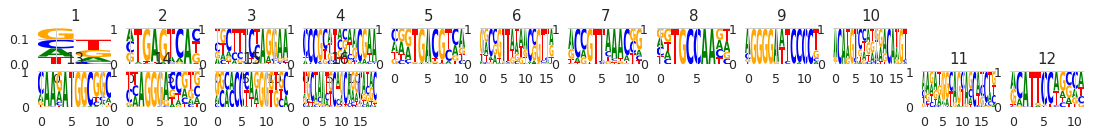

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

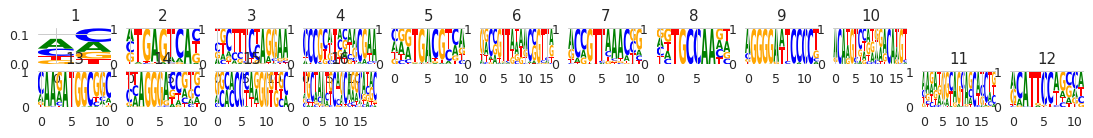

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

In [73]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 150

for optimize_log_dynamic in [False, True]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in selected_groups]
    model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(selected_groups):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    if optimize_log_dynamic:
        model.selex_module.conn_sparse = torch.tensor(ad.uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
        model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
        model = model.cuda()
        model.selex_module.log_dynamic.shape

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=range(2, 500),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

False


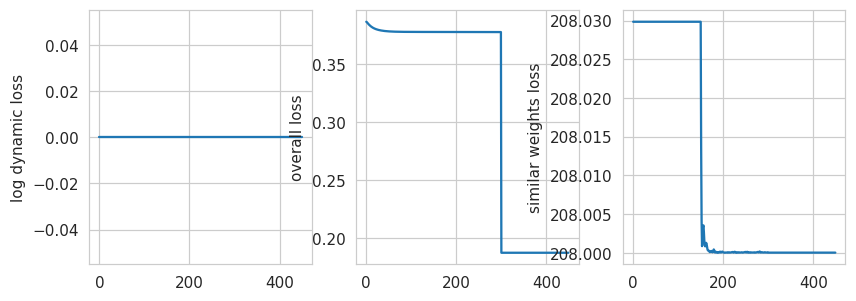

True


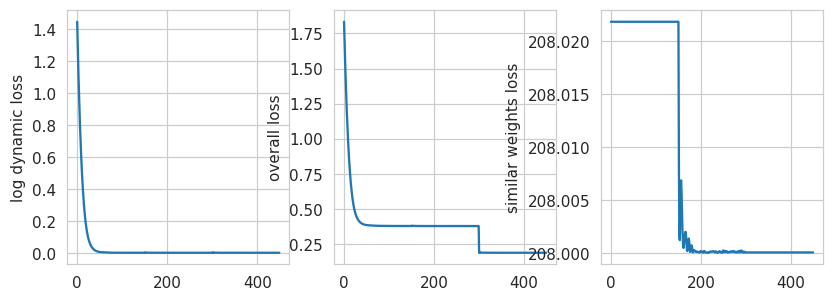

In [74]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    plt.subplot(1, 4, 1)
    plt.plot(model.loss_history_log_dynamic)
    plt.ylabel('log dynamic loss')
    plt.subplot(1, 4, 2)
    plt.plot(model.loss_history)
    plt.ylabel('overall loss')
    plt.subplot(1, 4, 3)
    plt.plot(model.loss_history_sym_weights)
    plt.ylabel('similar weights loss')
    plt.show()

False
True
3
0 None
0
None
0 out of 17...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(6, 3) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(6, 3) (1, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(6, 3) (1, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
(6, 3) (1, 0) 1
5 Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
(6, 3) (2, 1) 1
6 Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
(6, 3) (2, 2) 1
7 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 

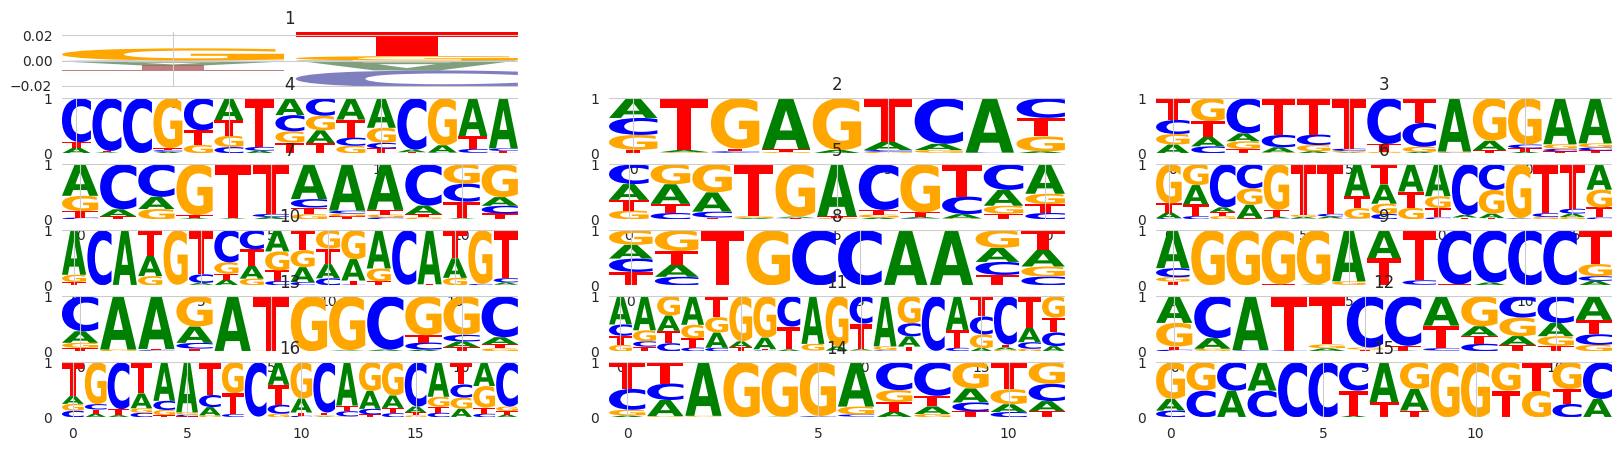

True
True
3
0 None
0
None
0 out of 17...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(6, 3) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(6, 3) (1, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(6, 3) (1, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
(6, 3) (1, 0) 1
5 Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
(6, 3) (2, 1) 1
6 Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
(6, 3) (2, 2) 1
7 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1

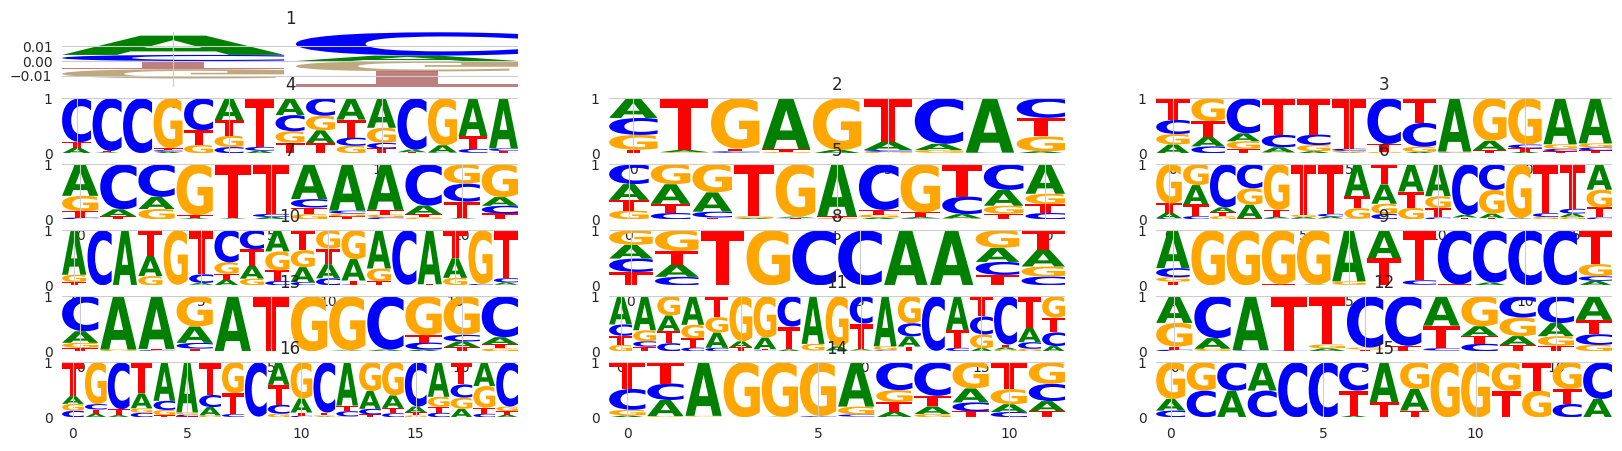

In [75]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.conv(model, n_cols=3, show=True, n_rows=6)
    plt.show()


True


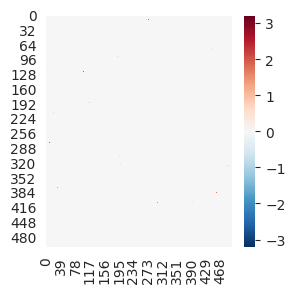

In [76]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.selex_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.selex_module.log_dynamic
    D = model.selex_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

False


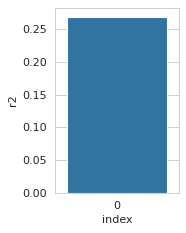

True


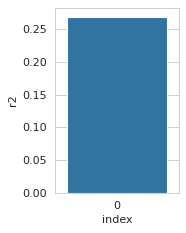

In [77]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    # contributions per newly added kernel
    rcParams['figure.figsize'] = 2, 3
    rcParams['figure.dpi'] = 80
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        sns.barplot(data=r2, x='index', y='r2')

    plt.show()

False
True


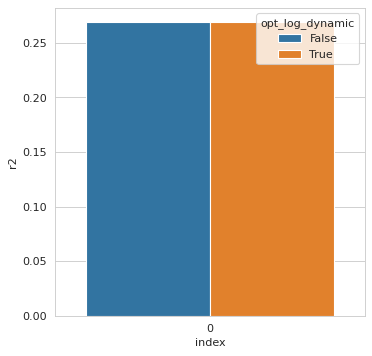

In [78]:
r2_net = None
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_net = r2 if r2_net is None else r2_net.append(r2)

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sns.barplot(data=r2_net, x='index', y='r2', hue='opt_log_dynamic')
plt.show()

In [79]:
r2_net

index        r2  opt_log_dynamic
0      0  0.268761            False
0      0  0.268761             True

In [106]:
model.binding_modes.prob_act

Parameter containing:
tensor([1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00,
        1.00, 1.00, 1.00, 1.00], device='cuda:0', requires_grad=True)

False
True


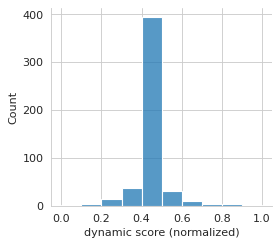

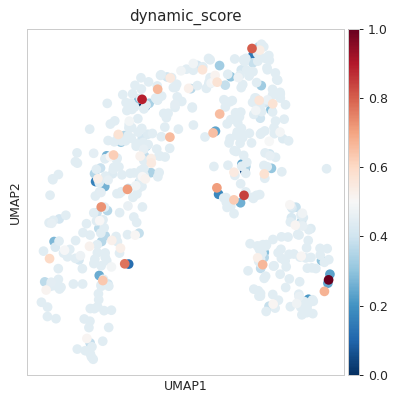

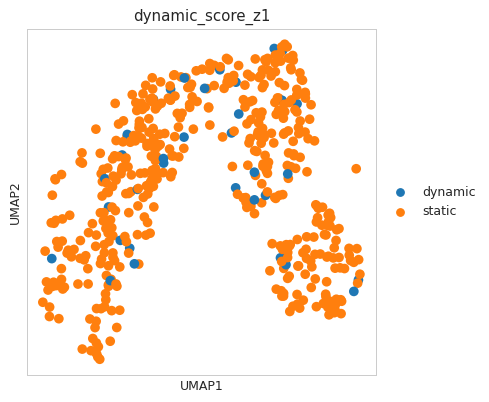

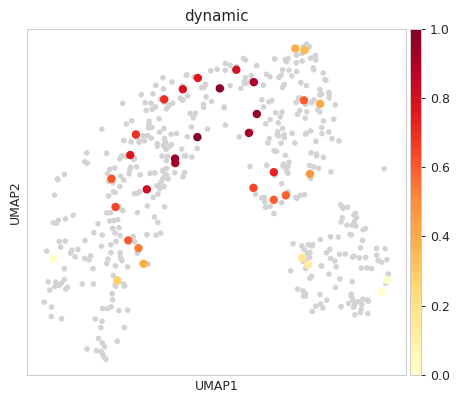

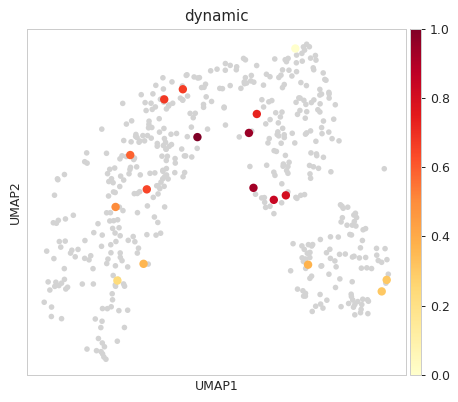

In [80]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    torch.set_printoptions(precision=2)
    dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
    # dyn_score
    dynamic_score = dynamic_score
    dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
    ad.obs['dynamic_score'] = dynamic_score

    ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
    z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
    z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

    ad.obs['dynamic_score_z1'] = z1
    ad.obs['dynamic_score_z2'] = z2

    #  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
    # mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    sns.displot(dynamic_score, height=3, aspect=1.2)
    plt.xlabel('dynamic score (normalized)')

    # contributions per newly added kernel
    mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
    sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
    sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

    sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
    sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
    sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
    sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

False


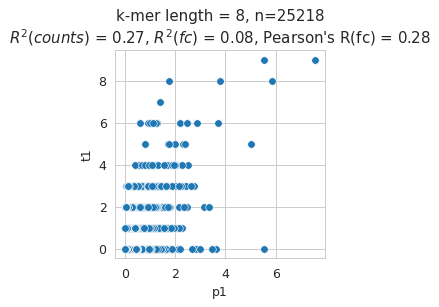

True
3
0 None
0
None
0 out of 17...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(12, 3) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(12, 3) (1, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(12, 3) (1, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
(12, 3) (1, 0) 1
5 Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
(12, 3) (2, 1) 1
6 Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
(12, 3) (2, 2) 1
7 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 

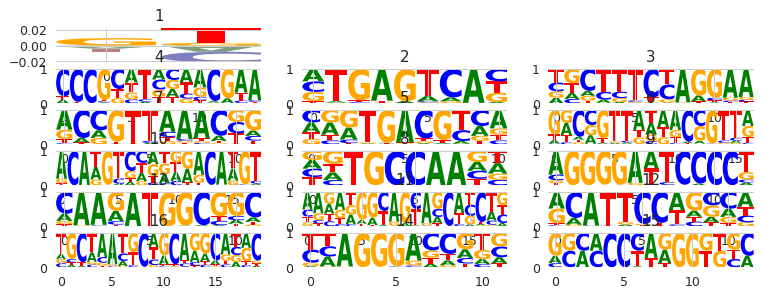

True


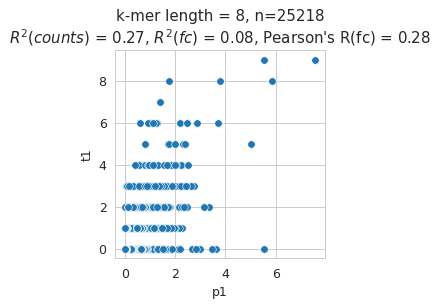

True
3
0 None
0
None
0 out of 17...
1 Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
1
Conv2d(1, 1, kernel_size=(4, 2), stride=(1, 1), bias=False)
(12, 3) (0, 0) 1
2 Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
2
Conv2d(1, 1, kernel_size=(4, 9), stride=(1, 1), bias=False)
(12, 3) (1, 1) 1
3 Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
3
Conv2d(1, 1, kernel_size=(4, 13), stride=(1, 1), bias=False)
(12, 3) (1, 2) 1
4 Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
4
Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
(12, 3) (1, 0) 1
5 Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
5
Conv2d(1, 1, kernel_size=(4, 11), stride=(1, 1), bias=False)
(12, 3) (2, 1) 1
6 Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
6
Conv2d(1, 1, kernel_size=(4, 17), stride=(1, 1), bias=False)
(12, 3) (2, 2) 1
7 Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 1), bias=False)
7
Conv2d(1, 1, kernel_size=(4, 12), stride=(1, 

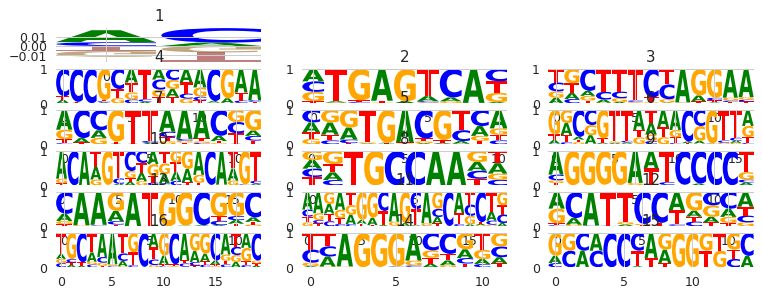

In [81]:
for optimize_log_dynamic in model_by_logdynamic:
    mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
    plt.show()

    mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
    mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=12, n_cols=3) # n_cols=len(reduced_groups))
    plt.show()


False
True
here...
(997, 500)
37742.0


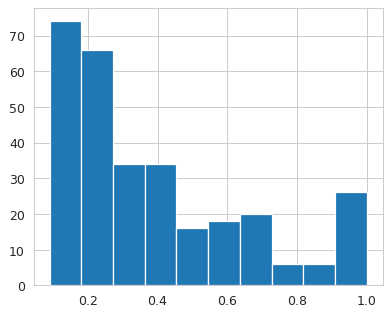

computing velocity graph (using 1/16 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


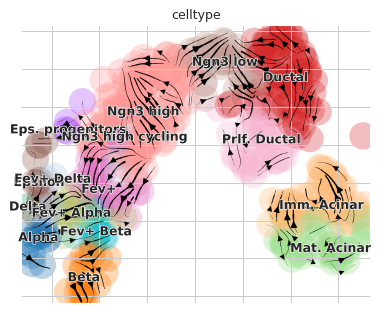

In [82]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'
        output = model(**inputs, use_conn=False)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    pred = np.concatenate(pred).T
    ad.layers['velocity'] = pred
    ad.layers['counts'] = ad.X

    mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())
    plt.show()

    import scvelo as scv

    sc.pp.neighbors(ad)

    scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    scv.pl.velocity_embedding_stream(ad, color='celltype') #  X_grid='X_umap', V=V)

In [83]:
rna = sc.read_h5ad(rna_path)
rna.shape
rna_sel = rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape
anno = mb.datasets.archetypes_anno()

In [84]:
rna_sel.shape

(500, 14663)

False


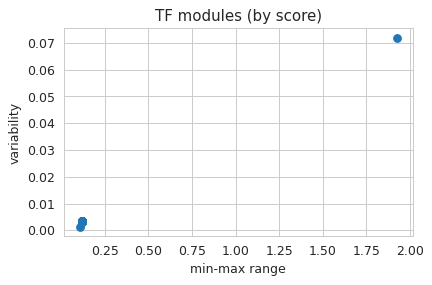

True


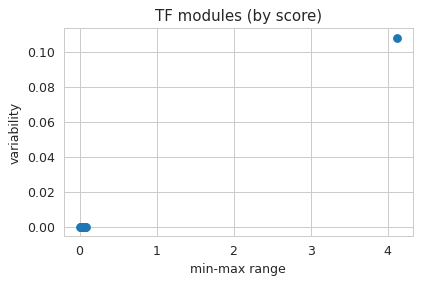

In [85]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

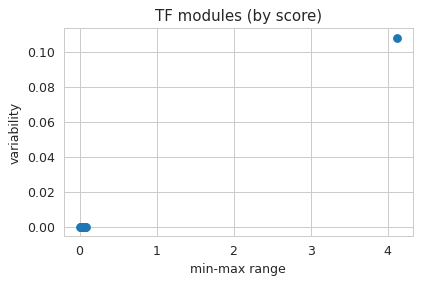

(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)
(500,) (500,)


In [86]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + sel_idx
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])


In [87]:
res.sort_values('spearman', ascending=False)

opt_log_dynamic archetype_id  spearman     p_val
15             True          260  0.098718  0.027296
4              True           10  0.088525  0.047883
3              True            8  0.084576  0.058781
12             True          214  0.083079  0.063416
16             True          269  0.082482  0.065348
14             True          222  0.082304  0.065933
10             True          160  0.081937  0.067151
11             True          173  0.080716  0.071344
8              True          127  0.078395  0.079900
9              True          130  0.078347  0.080083
13             True          219  0.076953  0.085619
1              True   dinuc_bias  0.072152  0.107084
5              True           12  0.071211  0.111752
7              True          117  0.066717  0.136283
6              True          116  0.066618  0.136869
2              True            2  0.065709  0.142323
0              True    intercept -0.093021  0.037589

In [88]:
log_act

intercept    dinuc_bias             2         8  \
AAACGGATCAGGTTTA-1-0  -0.338473  2.816911e-05  3.108618e-04  0.001284   
AAAGGACGTTAGGATT-1-0  -0.317892  8.285976e-08 -5.256958e-07 -0.000003   
AAATCCGGTTAGGCTA-1-0  -0.317892  8.285976e-08 -5.256958e-07 -0.000003   
AACATTGTCATTTGTC-1-0  -0.441368 -9.173573e-05 -1.236195e-03 -0.003211   
AACCGCTCATTAAAGG-1-0  -0.317892  8.285976e-08 -5.256958e-07 -0.000003   
...                         ...           ...           ...       ...   
TGTAATGTCGCGCTAA-1-1  -0.317892  8.285976e-08 -5.256958e-07 -0.000003   
TTATCCGTCCTTAAGA-1-1  -0.139363  6.474882e-05  9.041541e-04  0.002250   
TTCATTCAGGCACAGG-1-1  -0.328850  4.853605e-05  6.241094e-04  0.001547   
TTGTTTGGTAATTAGC-1-1   0.025019 -3.752943e-05 -4.644896e-04 -0.001339   
TTTCTTGCAATCTCTC-1-1   2.101237  3.291125e-04  4.032141e-03  0.009540   

                            10        12       116       117           127  \
AAACGGATCAGGTTTA-1-0  0.001325  0.000493  0.003968  0.000884  4.089860e-04   
AAAGGACGTTAGGATT-1-0  0.000014  0.000001  0.000005  0.000001  1.790774e-07   
AAATCCGGTTAGGCTA-1-0  0.000014  0.000001  0.000005  0.000001  1.790774e-07   
AACATTGTCATTTGTC-1-0 -0.005492 -0.001756 -0.008241 -0.002272 -1.679164e-03   
AACCGCTCATTAAAGG-1-0  0.000014  0.000001  0.000005  0.000001  1.790774e-07   
...                        ...       ...       ...       ...           ...   
TGTAATGTCGCGCTAA-1-1  0.000014  0.000001  0.000005  0.000001  1.790774e-07   
TTATCCGTCCTTAAGA-1-1  0.004074  0.001274  0.005927  0.001738  1.171753e-03   
TTCATTCAGGCACAGG-1-1  0.003521  0.000976  0.004226  0.001183  8.281493e-04   
TTGTTTGGTAATTAGC-1-1 -0.002798 -0.000734 -0.003637 -0.000958 -6.751656e-04   
TTTCTTGCAATCTCTC-1-1  0.016168  0.005881  0.020217  0.007307  5.440622e-03   

                           130       160       173           214  \
AAACGGATCAGGTTTA-1-0  0.000481  0.004399  0.006078  6.130791e-04   
AAAGGACGTTAGGATT-1-0 -0.000004 -0.000018  0.000032  4.161843e-07   
AAATCCGGTTAGGCTA-1-0 -0.000004 -0.000018  0.000032  4.161843e-07   
AACATTGTCATTTGTC-1-0 -0.004791 -0.011698 -0.014165 -2.409773e-03   
AACCGCTCATTAAAGG-1-0 -0.000004 -0.000018  0.000032  4.161843e-07   
...                        ...       ...       ...           ...   
TGTAATGTCGCGCTAA-1-1 -0.000004 -0.000018  0.000032  4.161843e-07   
TTATCCGTCCTTAAGA-1-1  0.003030  0.009111  0.009144  1.805807e-03   
TTCATTCAGGCACAGG-1-1  0.003173  0.005810  0.007970  1.275639e-03   
TTGTTTGGTAATTAGC-1-1 -0.002471 -0.004625 -0.005829 -1.045843e-03   
TTTCTTGCAATCTCTC-1-1  0.015543  0.025900  0.029101  7.777367e-03   

                               219       222       260       269  
AAACGGATCAGGTTTA-1-0  8.494412e-04  0.000580  0.000967  0.005271  
AAAGGACGTTAGGATT-1-0 -3.092509e-07  0.000005  0.000033 -0.000002  
AAATCCGGTTAGGCTA-1-0 -3.092509e-07  0.000005  0.000033 -0.000002  
AACATTGTCATTTGTC-1-0 -3.225960e-03 -0.002694 -0.006436 -0.016813  
AACCGCTCATTAAAGG-1-0 -3.092509e-07  0.000005  0.000033 -0.000002  
...                            ...       ...       ...       ...  
TGTAATGTCGCGCTAA-1-1 -3.092509e-07  0.000005  0.000033 -0.000002  
TTATCCGTCCTTAAGA-1-1  2.247924e-03  0.001726  0.004365  0.012304  
TTCATTCAGGCACAGG-1-1  1.964928e-03  0.001558  0.004673  0.010102  
TTGTTTGGTAATTAGC-1-1 -1.379849e-03 -0.001153 -0.003241 -0.007958  
TTTCTTGCAATCTCTC-1-1  1.029138e-02  0.008595  0.018948  0.033707  

[500 rows x 17 columns]

In [89]:
res = pd.DataFrame(pd.concat([delta, var], axis=1))
res['name'] = ['intercept', 'dinuc_bias'] + sel_idx
clu = mb.datasets.archetypes_clu()
res['archetypes_name'] = res['name'].map(anno.set_index('Cluster_ID')['Name'])
res['archetypes_seed'] = res['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])
res = res.sort_values(0, ascending=0)
res

0             1        name archetypes_name  \
intercept   4.117706  1.082153e-01   intercept             NaN   
269         0.083985  1.240337e-04         269          ZNF320   
173         0.075363  8.624119e-05         173          ZNF143   
160         0.070437  6.746974e-05         160          NFKB/1   
116         0.057756  3.788419e-05         116           PRDM5   
260         0.053195  3.242998e-05         260          ZNF329   
10          0.047191  2.320653e-05          10           HD/10   
130         0.045342  2.131119e-05         130            OSR2   
219         0.032767  9.249829e-06         219          ZNF250   
8           0.030672  8.258447e-06           8            HD/8   
222         0.027516  6.412864e-06         222          ZNF784   
214         0.025928  5.475310e-06         214           DMRT3   
117         0.024721  4.762499e-06         117      EWSR1/FLI1   
12          0.020074  3.033285e-06          12           HD/12   
127         0.018657  2.635116e-06         127           ZNF85   
2           0.014478  1.475787e-06           2            HD/2   
dinuc_bias  0.001232  9.707219e-09  dinuc_bias             NaN   

                  archetypes_seed  
intercept                     NaN  
269         ZN320_HUMAN.H11MO.0.C  
173         IKZF1_HUMAN.H11MO.0.C  
160         NFKB1_HUMAN.H11MO.1.B  
116         PRDM5_MOUSE.H11MO.0.A  
260         ZN329_HUMAN.H11MO.0.C  
10          HNF1A_HUMAN.H11MO.0.C  
130          OSR2_HUMAN.H11MO.0.C  
219         ZN250_HUMAN.H11MO.0.C  
8            ALX1_HUMAN.H11MO.0.B  
222                 ZNF784_C2H2_1  
214                DMRT3_MA0610.1  
117           EWSR1-FLI1_MA0149.1  
12           PBX1_HUMAN.H11MO.0.A  
127         ZNF85_HUMAN.H11MO.0.C  
2                   ALX3_MA0634.1  
dinuc_bias                    NaN

<AxesSubplot: xlabel='0', ylabel='archetypes_name'>

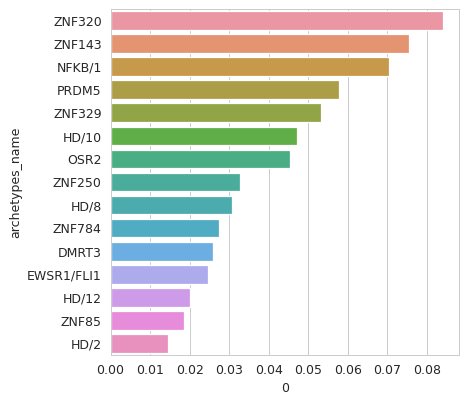

In [90]:
rcParams['figure.figsize'] = 5, 5
sns.barplot(data=res, x=0, y='archetypes_name')

In [91]:
mb.pl.set_rcParams({'figure.figsize': [3, 7], 'figure.dpi': 90})
# mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1,
#            n_rows=len(res.index), n_cols=1, order=res.index) # n_cols=len(reduced_groups))
plt.show()

In [92]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 6.165876


In [93]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [94]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [95]:
def find_varname(ad, k):
    return ad.var_names[ad.var_names.str.upper().str.contains(k.upper())]

In [96]:
from scipy.stats import spearmanr

In [97]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + sel_idx

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')

res = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + sel_idx

    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)

        next_targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            # print(name, target)
            for t in target:
                next_targets.add(t)

        for t in all_targets:
            gex = rna_sel.X[:,rna_sel.var_names == t]
            assert gex.shape[1] == 1
            gex = gex.A.flatten()
            # print(log_act.shape, gex.shape)
            # print(t, pearsonr(log_act, gex))
            res.append([optimize_log_dynamic, k, t, t in next_targets] +
                       list(spearmanr(log_act, gex)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

False
True
False
True


In [98]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
res[res['p_adj'] < 0.1]

opt_log_dynamic  archetype_id gene_name  matched  spearman     p_val  \
25              False             2     Rell1    False  0.143085  0.001337   
85              False             8     Rell1    False  0.138814  0.001863   
145             False            10     Rell1    False  0.143595  0.001284   
205             False            12     Rell1    False  0.142931  0.001353   
265             False           116     Rell1    False  0.143266  0.001318   
325             False           117     Rell1    False  0.140910  0.001585   
385             False           127     Rell1    False  0.141769  0.001482   
438             False           130      Isl1    False -0.137133  0.002118   
445             False           130     Rell1    False  0.138759  0.001871   
505             False           160     Rell1     True  0.139780  0.001729   
565             False           173     Rell1    False  0.142532  0.001396   
625             False           214     Rell1    False  0.142485  0.001401   
685             False           219     Rell1    False  0.142636  0.001385   
745             False           222     Rell1    False  0.143587  0.001285   
798             False           260      Isl1    False -0.136921  0.002152   
805             False           260     Rell1    False  0.143257  0.001319   
865             False           269     Rell1    False  0.144552  0.001190   
924              True             2   Kremen1     True -0.141682  0.001492   
932              True             2    Dlx1as     True -0.145103  0.001139   
984              True             8   Kremen1    False -0.148911  0.000838   
992              True             8    Dlx1as    False -0.145441  0.001109   
1044             True            10   Kremen1    False -0.154808  0.000513   
1052             True            10    Dlx1as    False -0.145098  0.001140   
1104             True            12   Kremen1    False -0.143485  0.001295   
1112             True            12    Dlx1as    False -0.145956  0.001064   
1164             True           116   Kremen1    False -0.141670  0.001493   
1172             True           116    Dlx1as    False -0.145528  0.001101   
1224             True           117   Kremen1    False -0.141498  0.001514   
1232             True           117    Dlx1as    False -0.145783  0.001079   
1284             True           127   Kremen1    False -0.150495  0.000736   
1292             True           127    Dlx1as    False -0.144593  0.001186   
1344             True           130   Kremen1    False -0.143601  0.001283   
1352             True           130    Dlx1as    False -0.144673  0.001179   
1404             True           160   Kremen1    False -0.156222  0.000455   
1412             True           160    Dlx1as    False -0.144591  0.001186   
1464             True           173   Kremen1    False -0.156350  0.000450   
1472             True           173    Dlx1as    False -0.144248  0.001219   
1524             True           214   Kremen1    False -0.148123  0.000893   
1532             True           214    Dlx1as    False -0.145441  0.001109   
1584             True           219   Kremen1    False -0.145151  0.001135   
1592             True           219    Dlx1as    False -0.144078  0.001236   
1644             True           222   Kremen1    False -0.153429  0.000576   
1652             True           222    Dlx1as    False -0.144330  0.001211   
1704             True           260   Kremen1    False -0.147538  0.000937   
1712             True           260    Dlx1as    False -0.143483  0.001295   
1764             True           269   Kremen1    False -0.156367  0.000449   
1772             True           269    Dlx1as    False -0.143826  0.001261   

         p_adj  
25    0.066452  
85    0.074825  
145   0.066452  
205   0.066452  
265   0.066452  
325   0.067911  
385   0.066452  
438   0.082408  
445   0.074825  
505   0.072396  
565   0.066452  
625   0.066452  
685   0.066452  
745   0.066452  
798   

In [99]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot('k', 'opt_log_dynamic', 'spearman')
df2['matched'] = res.pivot('k', 'opt_log_dynamic', 'matched')[False]

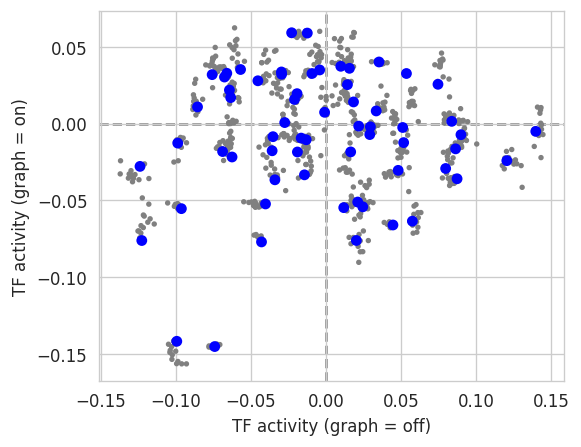

In [100]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
df2 = df2.sort_values('matched', ascending=True)
plt.scatter(df2[False], df2[True],
            color=np.where(df2['matched'], 'blue', 'gray'),
            s=np.where(df2['matched'], 30, 5))
plt.xlabel('TF activity (graph = off)')
plt.ylabel('TF activity (graph = on)')
plt.axhline(0, color='gray', ls='--', zorder=0)
plt.axvline(0, color='gray', ls='--', zorder=0)


In [101]:
df2[df2['matched'] == True].sort_values(True, ascending=False)

opt_log_dynamic     False      True  matched
k                                           
Relb_160        -0.022908  0.059064     True
Draxin_2        -0.012477  0.058848     True
Ikzf1_173        0.035308  0.040048     True
Hnf1aos1_10      0.009839  0.037243     True
Arel1_160        0.015609  0.035925     True
...                   ...       ...      ...
Kirrel2_160      0.020215 -0.076085     True
Mien1_2         -0.122758 -0.076114     True
Shox2_2         -0.042985 -0.077028     True
Kremen1_2       -0.099438 -0.141682     True
Dlx1as_2        -0.074156 -0.145103     True

[63 rows x 3 columns]

In [102]:
anno[anno['Cluster_ID'] == 96]

Cluster_ID   Name  DBD           Seed_motif  Total_width  Consensus_left  \
37          96  ETS/2  ETS  EHF_HUMAN.H11MO.0.B           18               3   

    Consensus_right  Cluster_size  
37               14            24

False


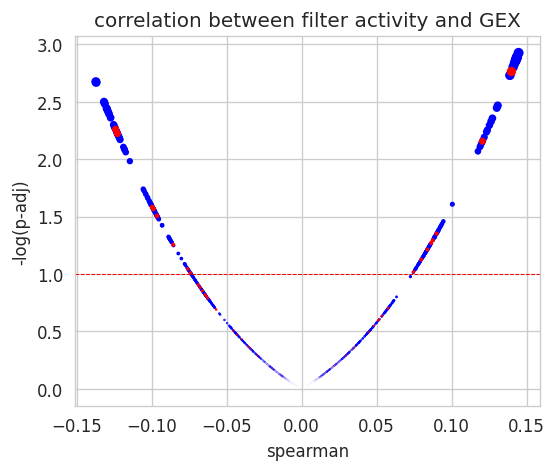

True


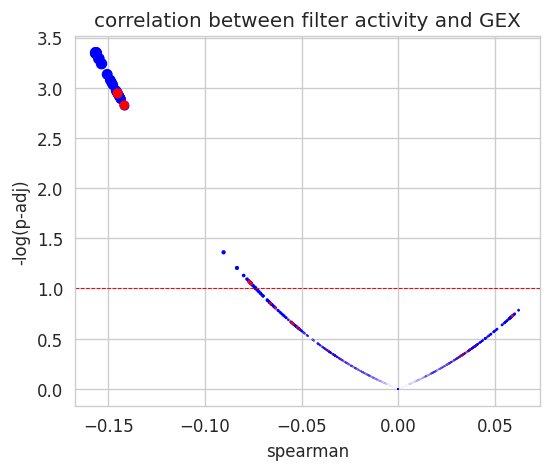

In [103]:
for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    print(optimize_log_dynamic)
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 3), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('correlation between filter activity and GEX')
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

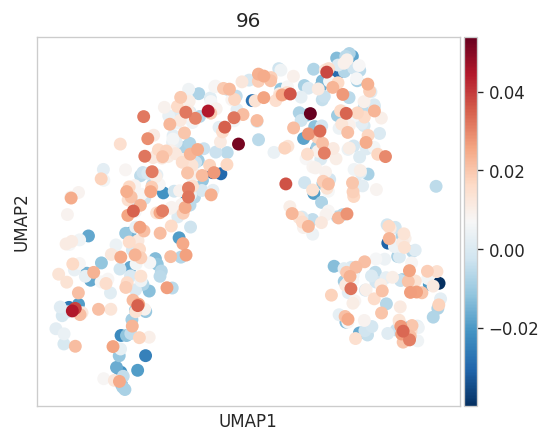

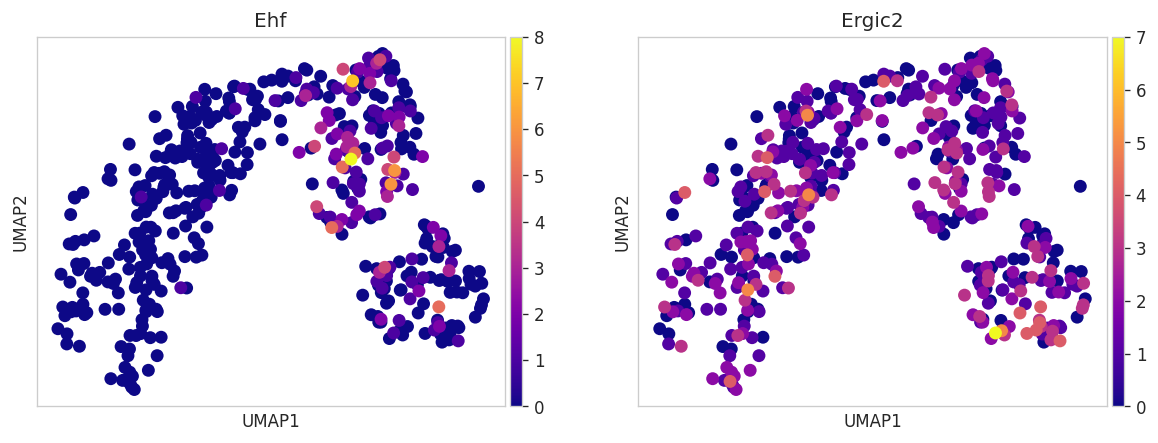

In [104]:
sc.pl.umap(ad, color=[96], cmap='RdBu_r')
sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

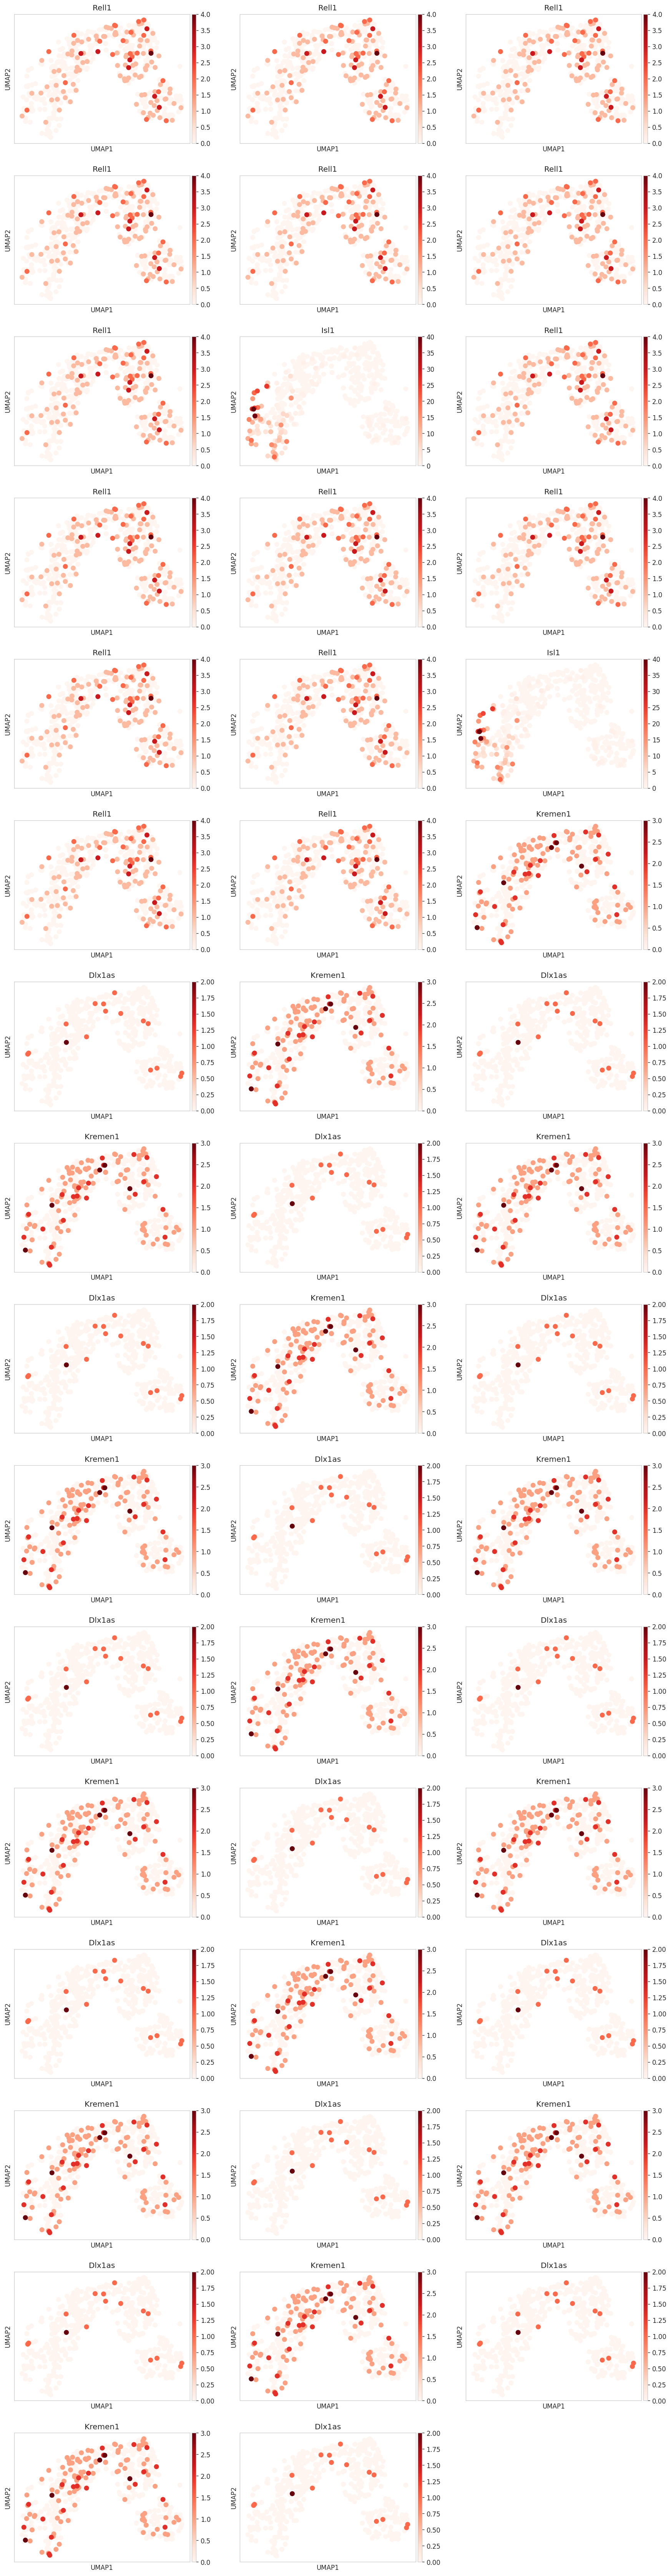

In [105]:
sc.pl.umap(rna_sel, color=list(res[res['p_adj'] < 0.1]['gene_name']),
           cmap='Reds', ncols=3)
